# Heatmap of T cell subpopulations

## Import statements

In [53]:
import os,sys
import datetime

In [54]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.06 GB, difference -0.14 GB


In [55]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [56]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("../utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_utility_spring as srz

## Functions

In [57]:
# I should move this function to rz_functions.py eventually
def get_fc_to_all_other(
    lab,
    meta,
    E,
    pseudo,
    gene_list,
    print_progression = False,
    ):
    
    """
    For each cluster i, find fold-change of a gene in i vs all other cells.
    
    input:
        lab - meta column name to group cell by
        meta - meta dataframe, cells x features
        E - sparse counts, cells x genes, same nr cells as meta
        pseudo - pseudovalue to add
        gene_list - gene list, matches the nr columns of E
        
    output:
        dictionary with cluster names as keys, and pd.Series of genes
        and their fold-change in cluster vs all other cells/
    
    example of use:
        
        
        fcdict = get_fc_to_all_other(
        lab = thelabel,
        meta = meta[cellmask_to_use],
        E = Enorm[cellmask_to_use,:],
        pseudo = pseudo,
        gene_list = gene_list
        )
    
    
    """
    
    resdict = {}
    
    for cl in meta[lab].unique():
        mask = (meta[lab] == cl).values
        maskinv = ~mask

        # selected cells
        left = np.array(E[mask,:].todense())

        # all other cells
        right = np.array(E[maskinv,:].todense())

        # fold-change
        fc = pd.Series((left.mean(axis=0)+pseudo)/(right.mean(axis=0)+pseudo),index=gene_list)
        resdict[cl] = fc
        
        if print_progression:
            print(cl)

    return resdict

# rename for easy code recycling once I move
# the function to 
rz.get_fc_to_all_other = get_fc_to_all_other
del get_fc_to_all_other

## Load counts

In [58]:
# I need to load data to show expression...
adata = sc.read_h5ad('../data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')
# normalize
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Overwrite adata.obs with the most recent per-cell detail

In [59]:
adata.obs = rz.load_df('../data/obs_info_27563x32_201025_14h44.npz')

In [60]:
adata.obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3,sp_cl_all_cells_clean_iter3_100,used_in_T_cells_only_iter2,Major cell type
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,...,False,True,68,B cells,False,mB cells,True,13,False,B cells
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,...,False,True,4,NK cells,False,mNK cells,True,33,False,NK cells
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,...,False,True,75,N4,False,mN4,True,31,False,Neutrophils
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,...,False,True,41,Mac1,False,mMac1,True,18,False,Monocytes/Macrophages
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,...,False,True,1,Mono1,False,mMono1,True,89,False,Monocytes/Macrophages


## Identify subset-enriched genes

### Select T cells only and get centroids

In [61]:
cmask = adata.obs['*population']\
.isin(["ILC","T_Cd4","T_Cd8_Ccr7hi","T_Cd8_Cxcr3hi","Tgd","Treg","NK cells"]).values
print(cmask.sum())

2873


In [62]:
# get centroids
thelabel = '*population'
centroids = rz.centroids(thelabel,adata[cmask])
centroids

index,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
NK cells,0.059315,0.015670,0.130488,0.014858,0.075126,0.084109,0.110798,0.122143,0.034172,0.343265,...,0.0,0.0,0.0,0.0,0.0,0.016782,0.0,0.0,0.0,0.0
T_Cd8_Cxcr3hi,0.015056,0.000000,0.045182,0.018876,0.028574,0.032319,0.084936,0.014343,0.000000,0.465790,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
T_Cd8_Ccr7hi,0.031089,0.005016,0.087698,0.005384,0.030990,0.031045,0.100995,0.053145,0.000000,0.583784,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
T_Cd4,0.038317,0.013624,0.111576,0.000000,0.031145,0.065897,0.030224,0.108996,0.000000,0.420943,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Treg,0.013931,0.000000,0.043780,0.000000,0.038012,0.144722,0.169093,0.060991,0.000000,0.470916,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Tgd,0.041973,0.000000,0.057021,0.000000,0.159612,0.029608,0.000000,0.000000,0.000000,0.575189,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ILC,0.000000,0.000000,0.153230,0.000000,0.000000,0.065436,0.000000,0.087793,0.000000,1.198032,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Pre-filter low-expression genes

In [63]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 10
min_cells = 5

In [64]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

8267 genes passing abundance filter


### Compare each subset to all other T cells, MWU test

In [65]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

1000
2000
3000
4000
5000
6000
7000
8000
1/7
NK cells done 2873
1000
2000
3000
4000
5000
6000
7000
8000
2/7
T_Cd8_Cxcr3hi done 2873
1000
2000
3000
4000
5000
6000
7000
8000
3/7
T_Cd8_Ccr7hi done 2873
1000
2000
3000
4000
5000
6000
7000
8000
4/7
T_Cd4 done 2873
1000
2000
3000
4000
5000
6000
7000
8000
5/7
Treg done 2873
1000
2000
3000
4000
5000
6000
7000
8000
6/7
Tgd done 2873
1000
2000
3000
4000
5000
6000
7000
8000
7/7
ILC done 2873
21.58931589126587


### Calculate on fold-change for each genes (within population vs the rest of T cells)

In [66]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [67]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

*population


### Leave only significantly enriched genes

In [68]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

8267
NK cells 2294 2294
T_Cd8_Cxcr3hi 435 435
T_Cd8_Ccr7hi 1533 1533
T_Cd4 1733 1733
Treg 1292 1292
Tgd 537 537
ILC 388 388


# Select up to 40 genes with the highest-fold change

In [69]:
# nr genes to consider:
upto = 40

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

NK cells_FC         4.055233
T_Cd8_Cxcr3hi_FC    1.558958
T_Cd8_Ccr7hi_FC     1.540455
T_Cd4_FC            1.586111
Treg_FC             1.990619
Tgd_FC              2.056033
ILC_FC              3.492374
dtype: float32

In [70]:
frame

,NK cells,NK cells_FC,T_Cd8_Cxcr3hi,T_Cd8_Cxcr3hi_FC,T_Cd8_Ccr7hi,T_Cd8_Ccr7hi_FC,T_Cd4,T_Cd4_FC,Treg,Treg_FC,Tgd,Tgd_FC,ILC,ILC_FC
0,Gzma,54.484161,Tcrg-C2,3.032261,Cd8b1,3.264244,AC160336.1,2.596690,Ikzf2,4.549704,Tmem176b,8.536950,Fgl2,9.942371
1,Gzmb,20.073029,Cxcr6,2.553988,Cd8a,2.525358,Rflnb,2.527436,Ctla4,4.499186,Tmem176a,5.476097,Ctla2a,9.811911
2,Prf1,13.926462,S100a6,2.384303,Dapl1,2.144060,Igfbp4,2.447281,S100a4,4.291314,Lmo4,5.324800,Egr1,8.633501
3,Fcer1g,13.231569,Ccl5,2.336561,Rpl12,1.839266,Gm12840,2.390316,Icos,3.774925,Cxcr6,5.011240,Prnp,8.219974
4,Irf8,12.549376,Tcrg-C4,2.334489,Gas5,1.834908,Lef1,2.345400,Maf,3.593892,S100a4,3.922130,Rnf128,7.595976
5,Tyrobp,11.688313,Trdc,2.101215,Rps19,1.828171,Actn1,2.323688,Tnfrsf4,3.441964,Rora,3.862955,Hes1,6.727567
6,Klrb1c,11.611063,Itga1,2.051750,Rpl36a,1.827097,S1pr1,2.309091,Odc1,3.313921,Tcrg-C1,3.640696,Il1rl1,6.648002
7,Ccl5,10.601738,Il2rb,2.043509,Eef1b2,1.773080,AC111046.1,2.206472,Foxp3,2.841864,Serpinb1a,3.084757,Il2ra,6.588933
8,Klra4,10.311733,Serpina3g,2.010203,Rps28,1.713303,Ccr7,2.090619,Hif1a,2.839068,Maf,2.741806,Rgs2,6.395591
9,Klre1,9.687276,Tnfsf10,1.946974,Rps20,1.705929,Cd4,2.044175,Ly6a,2.722246,Il17re,2.685345,Hs3st1,6.294415


In [71]:
clnames = sorted(fcdictsig.keys())
clnames

['ILC', 'NK cells', 'T_Cd4', 'T_Cd8_Ccr7hi', 'T_Cd8_Cxcr3hi', 'Tgd', 'Treg']

## Plot heatmap

### Prep data

In [72]:
import scipy
import scipy.cluster

In [73]:
# select only columns with gene names:
genes = frame[clnames].T.values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

##hierarchically cluster
hierdict = rz.hier_cluster(heat,method='average',metric='correlation')

print(hierdict.keys())

heat = hierdict['data']

280
236
dict_keys(['data', 'row_link', 'col_link'])


In [74]:
# select gene names to print in the heatmap
totick = [
 'Cd4','Cd8a','Cd8b1',
 'Ccr7',
    'Ctla4','Foxp3','Calca','Il17re','Ifng','Cxcr3'
]

-2.6536865 6.7174463
heatmap_*population_upto_40_201025_14h51


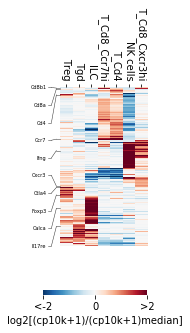

In [75]:
a,fig,gs = rz.startfig(6,12,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
rz.yticks_fancy(a,totick,labels_all = heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
plt.savefig('outputs/'+'%s.pdf'%fname,dpi=600)

In [76]:
# save the pandas dataframe colored as in the heatmap to excel
colored = rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,
                         cmap=mpl.cm.get_cmap('RdBu_r'))


colored.to_excel('outputs/heatmap_T_subsets_up_to_%d.xlsx'%upto)
colored

In [77]:
!open .